In [1]:
# Librerías
import pandas as pd
import os
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from bs4 import BeautifulSoup
import re

In [2]:
zona_local="America/Santiago"
ruta_base = "C:/Users/catal/Downloads/collaborations-2025-delirium-visualization-main/collaborations-2025-delirium-visualization-main/data/2022/07"
nombre_base = "corrections_report"
formato_fecha = "%Y-%m-%d" 

In [3]:
# Parámetros de entrada
fecha_inicio = datetime(2022, 7, 10)
fecha_fin = datetime(2022, 7, 15)

# Convertir fechas a UTC
dt_inicio_utc = fecha_inicio.replace(tzinfo=ZoneInfo(zona_local)).astimezone(ZoneInfo("UTC"))
dt_fin_utc = fecha_fin.replace(tzinfo=ZoneInfo(zona_local)).astimezone(ZoneInfo("UTC"))

In [5]:
# Recorrer fechas y procesar archivos HTML
# Oculto en funciones
resultados = []

fecha_actual = fecha_inicio
while fecha_actual <= fecha_fin:
    fecha_str = fecha_actual.strftime(formato_fecha)
    nombre_archivo = f"{nombre_base}_{fecha_str}.html"
    path = os.path.join(ruta_base, nombre_archivo)

    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            html = f.read()
            soup = BeautifulSoup(html, "lxml")
            # Función que extrae tablas de un archivo HTML y las devuelve como una lista de DataFrames
            tablas = pd.read_html(path, index_col=0)
            # Tablas impares con la información de 
            for i in range(0, len(tablas) - 1, 2):
                # Número de filas que tiene tablas[1]
                n_repeat = tablas[i + 1].shape[0]
                # Nuestra intención es extraer la información de "Timestamp" y "Delay line number" para agregarlas como columnas nuevas
                tabla_transpuesta = tablas[i].T
                if all(col in tabla_transpuesta.columns for col in ["Timestamp", "Delay line number"]):
                    test_pd = tabla_transpuesta[["Timestamp", "Delay line number"]]
                    # Hace que los Timestamp pasen a formato datetime64 (formato de fecha y hora estandarizado)
                    test_pd["Timestamp"] = pd.to_datetime(test_pd["Timestamp"])

                    # Validamos que test_pd no esté vacío y que n_repeat sea mayor que 0
                    if not test_pd.empty and n_repeat > 0:
                        # Concatenamos el dataframe a que se repita la misma cantidad de veces que el n° de correcciones y limpiamos el índice
                        test_pd_repeated = pd.concat([test_pd] * n_repeat).reset_index(drop=True)

                        # Eliminamos el nivel 0 del índice de columnas, Cambiamos el nombre del índice a "Rail number" y lo movemos de columna
                        tabla_correcciones = tablas[i + 1].droplevel(0, axis=1).rename_axis("Rail number").reset_index(drop=False)

                        # "Tunnel Relative Humidity" se encuentra como la etiqueta h3
                        h3_tags = soup.find_all("h3")
                        h3_texts = [tag.text for tag in h3_tags]

                        # Extraemos el porcentaje de humedad del texto
                        humidity = None
                        for tag in h3_tags:
                            texto = tag.get_text()
                            match = re.search(r"(\d+(\.\d+)?)%", texto)
                            if match:
                                porcentaje = match.group(1)
                                humidity = float(porcentaje)
                                break

                        # Creamos una tabla 
                        if humidity is not None:
                            porc_pd_repeated = pd.DataFrame({"Tunnel Relative Humidity": [f"{humidity}%"] * n_repeat})
                        else:
                            porc_pd_repeated = pd.DataFrame({"Tunnel Relative Humidity": [None] * n_repeat})

                        pd_result = pd.concat([test_pd_repeated, porc_pd_repeated, tabla_correcciones], axis=1)

                        # Concatenamos ambas tablas anteriormente realizadas
                        print(pd_result)
                        print(f"Archivo procesado: {nombre_archivo}")

                        resultados.append(pd_result)
                    else:
                        print(f"test_pd vacío o n_repeat = 0 en archivo {nombre_archivo}")
                else:
                    print(f"Columnas faltantes en tabla {i} del archivo {nombre_archivo}")
    else:
        print(f"Archivo no encontrado: {nombre_archivo}")

    fecha_actual += timedelta(days=1)

C:\Users\catal\AppData\Local\Temp\ipykernel_22132\2967276778.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pd["Timestamp"] = pd.to_datetime(test_pd["Timestamp"])
C:\Users\catal\AppData\Local\Temp\ipykernel_22132\2967276778.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pd["Timestamp"] = pd.to_datetime(test_pd["Timestamp"])
C:\Users\catal\AppData\Local\Temp\ipykernel_22132\2967276778.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

            Timestamp Delay line number Tunnel Relative Humidity  Rail number  \
0 2022-07-10 09:54:00                 1                    10.1%           29   
1 2022-07-10 09:54:00                 1                    10.1%           35   
2 2022-07-10 09:54:00                 1                    10.1%           38   
3 2022-07-10 09:54:00                 1                    10.1%           42   
4 2022-07-10 09:54:00                 1                    10.1%           43   
5 2022-07-10 09:54:00                 1                    10.1%           58   
6 2022-07-10 09:54:00                 1                    10.1%           70   
7 2022-07-10 09:54:00                 1                    10.1%           72   
8 2022-07-10 09:54:00                 1                    10.1%           77   

   horizontal  vertical  
0           8         0  
1          10         0  
2           0        -7  
3         -16         0  
4          -9         0  
5           9         0  
6      

C:\Users\catal\AppData\Local\Temp\ipykernel_22132\2967276778.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pd["Timestamp"] = pd.to_datetime(test_pd["Timestamp"])
C:\Users\catal\AppData\Local\Temp\ipykernel_22132\2967276778.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pd["Timestamp"] = pd.to_datetime(test_pd["Timestamp"])
C:\Users\catal\AppData\Local\Temp\ipykernel_22132\2967276778.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

            Timestamp Delay line number Tunnel Relative Humidity  Rail number  \
0 2022-07-13 10:08:55                 3                    11.0%           16   
1 2022-07-13 10:08:55                 3                    11.0%           17   
2 2022-07-13 10:08:55                 3                    11.0%           18   
3 2022-07-13 10:08:55                 3                    11.0%           19   
4 2022-07-13 10:08:55                 3                    11.0%           21   
5 2022-07-13 10:08:55                 3                    11.0%           66   
6 2022-07-13 10:08:55                 3                    11.0%           68   
7 2022-07-13 10:08:55                 3                    11.0%           69   
8 2022-07-13 10:08:55                 3                    11.0%           70   
9 2022-07-13 10:08:55                 3                    11.0%           77   

   horizontal  vertical  
0           0        -8  
1           0        -8  
2           0        -7  
3   

In [6]:
# Exportar a Excel
df_final = pd.concat(resultados, ignore_index=True)
df_final["Timestamp"] = df_final["Timestamp"].dt.strftime("%Y-%m-%d %H:%M") # Transformamos a string las fechas para poder verlas en excel
df_final.to_excel("C:/Users/catal/Downloads/collaborations-2025-delirium-visualization-main/collaborations-2025-delirium-visualization-main/resultados.xlsx", index=False)
print(df_final.head())

          Timestamp Delay line number Tunnel Relative Humidity  Rail number  \
0  2022-07-10 09:54                 1                    10.1%           29   
1  2022-07-10 09:54                 1                    10.1%           35   
2  2022-07-10 09:54                 1                    10.1%           38   
3  2022-07-10 09:54                 1                    10.1%           42   
4  2022-07-10 09:54                 1                    10.1%           43   

   horizontal  vertical  
0           8         0  
1          10         0  
2           0        -7  
3         -16         0  
4          -9         0  


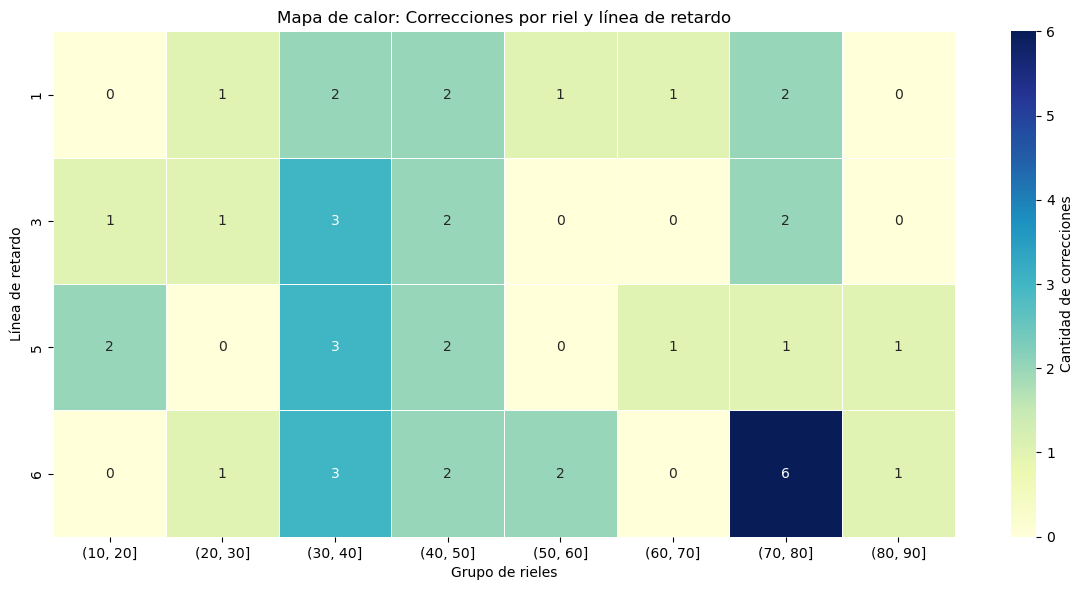

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapa de calor que depende de la cantidad de los rails corrections y delay line number (rectángulo de 6 líneas)

rail_number = df_final["Rail number"]

df_final["rail_bin"] = pd.cut(df_final["Rail number"], bins=range(0, df_final["Rail number"].max() + 10, 10))

tabla = pd.crosstab(df_final["Delay line number"], df_final["rail_bin"])

# Paso 3: Graficar el mapa de calor
plt.figure(figsize=(12, 6))
sns.heatmap(tabla, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Cantidad de correcciones"})

plt.title("Mapa de calor: Correcciones por riel y línea de retardo")
plt.xlabel("Grupo de rieles")
plt.ylabel("Línea de retardo")
plt.tight_layout()
plt.show()

C:\Users\catal\AppData\Local\Temp\ipykernel_6268\773948676.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabla_magnitud = df_final.pivot_table(


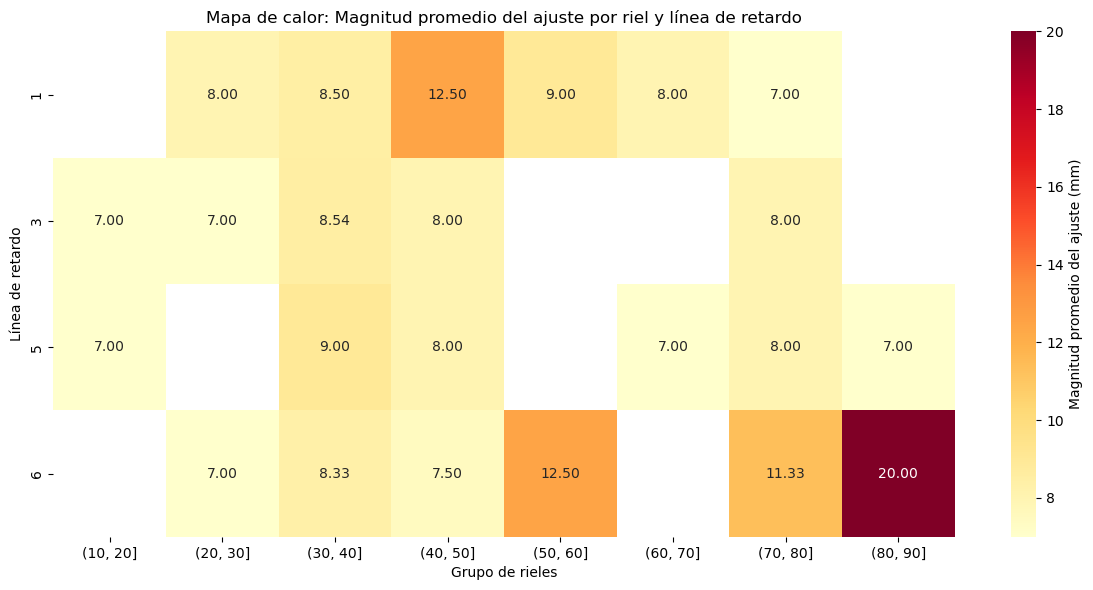

In [ ]:
import numpy as np

# Calcular magnitud total
df_final["magnitud"] = np.sqrt(df_final["horizontal"]**2 + df_final["vertical"]**2)

# Crear tabla de promedio de magnitud
tabla_magnitud = df_final.pivot_table(
    index="Delay line number",
    columns="rail_bin",
    values="magnitud",
    aggfunc="mean"
)

# Graficar
plt.figure(figsize=(12, 6))
sns.heatmap(tabla_magnitud, annot=True, fmt=".2f", cmap="YlOrRd",
            cbar_kws={"label": "Magnitud promedio del ajuste (mm)"})
plt.title("Mapa de calor: Magnitud promedio del ajuste por riel y línea de retardo")
plt.xlabel("Grupo de rieles")
plt.ylabel("Línea de retardo")
plt.tight_layout()
plt.show()